In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import os
import matplotlib.pyplot as plt

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Testing baseline dataset variants

XGBoost classifier wrapped in multi-output classifer (best macro-average F1 score in prior tests), versus three different arrangements:

- 48 hours time series, implicit (48)

- alternate variable layout (newvar)

- 24 hours time series, explicit (ts_24)

- tsnv_24, both options 2 and 3 together

## Conclusions

- 24 hours implicit time series/original dataset (20 Jan 2021)

  Brier score losses: \[0.024548 0.019501 0.013385 0.009749\]
  
  f1-score: \[0.82817 0.83697 0.79851 0.72368\] averages to 0.79683


Tests conducted 20 Jan 2021:

- 48h version

  Brier score losses: \[0.022626 0.019071 0.008700 0.007085\] = improvement observed
  
  f1-score: \[0.83544  0.82231 0.81111 0.77778\] averages to 0.81166 (0.832 in alt. run 5 Feb) = improvement in 3/4 cases
  
  
- newvar
  
  Brier score losses: \[0.023839 0.022648 0.008035 0.007475\] = improvement observed
  
  f1-score: \[0.82961 0.79798 0.80583 0.78014\] averages to 0.80339 = improvement in 3/4 cases
  

- ts_24

  Brier score losses: \[0.020553 0.015959 0.008150 0.008077\] = improvement observed
  
  f1-score: \[0.86022 0.85665 0.80751 0.72848\] averages to 0.81321 = improvment in all areas
  
  
- tsnv_24

  Brier score losses: \[0.022455 0.020122 0.008120 0.011032\] = improvement in 2/4 cases
  
  f1-score: \[0.85638 0.83819 0.81057 0.69663\] averages to 0.80044 = improvement in 3/4 cases
  
  
- downsampled tsnv_24 (conducted March 2022)

  Brier score losses: \[0.013957 0.006784 0.003802 0.003947\] = improvement in all  
  
  f1-score  \[0.94017 0.93023 0.93750 0.90909\] averages to 0.92925 = improvement in all areas
  
  ExtraTrees can also get average f1 of > 0.9.
  
All baseline models have generally been retrofitted (kind of) to tsnv_24 and downsampled tsnv_24 separately. Please look inside the details of each notebook to see which ones used which, or consult the readme file. 

For a comprehensive overview of all baseline models' performances, please use the overview notebooks.

### Read first dataset

In [4]:
dataset = pd.read_pickle('../Dataset/baseline_dataset_48.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37413 entries, 0 to 37412
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             37413 non-null  int64  
 1   DD             37413 non-null  int64  
 2   HH             37413 non-null  int64  
 3   LOW_IMPACT     37413 non-null  bool   
 4   MID_IMPACT     37413 non-null  bool   
 5   BIG_IMPACT     37413 non-null  bool   
 6   DIRECT_STRIKE  37413 non-null  bool   
 7   00LAT          37413 non-null  float32
 8   00LON          37413 non-null  float32
 9   00VMAX         37413 non-null  int32  
 10  06LAT          37413 non-null  float32
 11  06LON          37413 non-null  float32
 12  06VMAX         37413 non-null  int32  
 13  12LAT          37413 non-null  float32
 14  12LON          37413 non-null  float32
 15  12VMAX         37413 non-null  int32  
 16  18LAT          37413 non-null  float32
 17  18LON          37413 non-null  float32
 18  18VMAX

In [3]:
# imports (lazy)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn import tree, ensemble, neural_network
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

# Constants
TRAIN_RATIO = 0.9

In [5]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,3:7]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 30303; Dev set size: 3368; Testing set size: 3742


### Support functions

In [6]:
# make calibration plots for class (label) 0 and 3
def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")    
    all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain):
            preds = all_preds[:,i]
        else:
            preds = all_preds[i,:,1]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = np.array(clf.predict_proba(dataset_X))
    preds = preds[:,0] if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain) else preds[0,:,1]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = np.array(clf.predict_proba(dataset_X))
    preds = preds[:,3] if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain) else preds[3,:,1]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [7]:
# optimize thresholds; also two versions
def optimize_thresholds(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    # find the best decision thresholds and the corresponding F1 scores
    all_preds = np.array(clf.predict_proba(dataset_X))
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain):
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[:,i])
        else:
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[i,:,1])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the last class/label
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

In [8]:
def predictions_with_thresholds(clf, thresholds, dataset_X):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = np.array(clf.predict_proba(dataset_X))
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain):
        for i in range(preds_probs.shape[0]):
            pred_row = []
            for j in range(n_classes):
                if preds_probs[i,j] > thresholds[j]:
                    pred_row.append(1)
                else:
                    pred_row.append(0)
            preds.append(pred_row)
    else:
        for i in range(preds_probs.shape[1]):
            pred_row = []
            for j in range(n_classes):
                if preds_probs[j,i,1] > thresholds[j]:
                    pred_row.append(1)
                else:
                    pred_row.append(0)
            preds.append(pred_row)
    
    return np.array(preds)

In [9]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)

### Fit model
#### XGB Multioutput Classifier
had the best macro-average f1-score, was thus chosen

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.023477
Class 1, no calibration: 0.014625
Class 2, no calibration: 0.010972
Class 3, no calibration: 0.006275


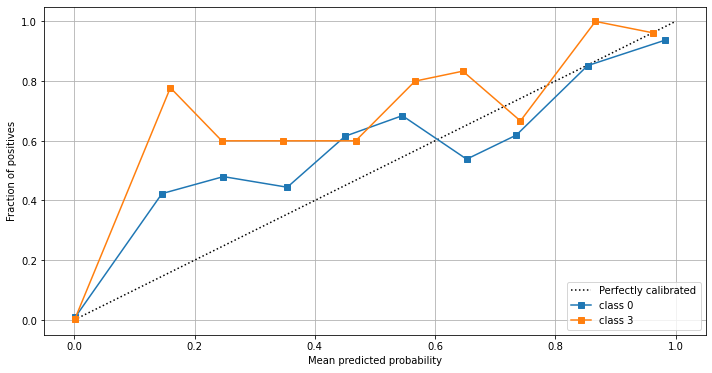

In [10]:
multiout_xgb_model = MultiOutputClassifier(xgb.XGBClassifier(
    n_estimators=400, max_depth=20, tree_method='gpu_hist'
), n_jobs=-1)
multiout_xgb_model.fit(train_X, train_Y)

calibration_plot(multiout_xgb_model, dev_X, dev_Y)

Best Threshold=0.11288, F-Score=0.83306
Best Threshold=0.37008, F-Score=0.87305
Best Threshold=0.07489, F-Score=0.78788
Best Threshold=0.09829, F-Score=0.85496


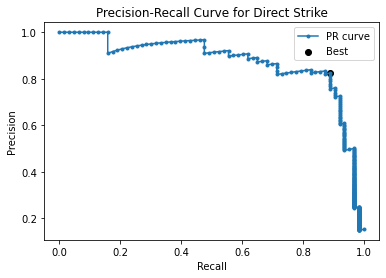

In [11]:
best_thresholds, best_f1_scores = optimize_thresholds(multiout_xgb_model, dev_X, dev_Y)

In [12]:
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9444774347
              precision    recall  f1-score   support

           0    0.78049   0.88889   0.83117       288
           1    0.88235   0.85903   0.87054       227
           2    0.70312   0.88235   0.78261       102
           3    0.82090   0.87302   0.84615        63

   micro avg    0.80108   0.87647   0.83708       680
   macro avg    0.79672   0.87582   0.83262       680
weighted avg    0.80663   0.87647   0.83841       680
 samples avg    0.09573   0.09974   0.09587       680



In [13]:
save_sklearn_model_to_file(multiout_xgb_model, "48h_ds_xgboost_multioutput_400")

### Alternative variable layout

In [14]:
dataset = pd.read_pickle('../Dataset/baseline_dataset_newvars.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             45293 non-null  int64  
 1   DD             45293 non-null  int64  
 2   LOW_IMPACT     45293 non-null  bool   
 3   MID_IMPACT     45293 non-null  bool   
 4   BIG_IMPACT     45293 non-null  bool   
 5   DIRECT_STRIKE  45293 non-null  bool   
 6   DIST00         45293 non-null  float64
 7   AZM00          45293 non-null  float64
 8   SPEED00        45293 non-null  int32  
 9   DIR00          45293 non-null  int32  
 10  VMAX00         45293 non-null  int32  
 11  DVMAX00        45293 non-null  int32  
 12  DIST06         45293 non-null  float64
 13  AZM06          45293 non-null  float64
 14  SPEED06        45293 non-null  int32  
 15  DIR06          45293 non-null  int32  
 16  VMAX06         45293 non-null  int32  
 17  DVMAX06        45293 non-null  int32  
 18  DIST12

In [15]:
def pandasToXY(dataframe):
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,2:6]).astype(int) # different because no HH
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36686; Dev set size: 4077; Testing set size: 4530


Brier score losses: (the smaller the better)
Class 0, no calibration: 0.026620
Class 1, no calibration: 0.018986
Class 2, no calibration: 0.008750
Class 3, no calibration: 0.007764


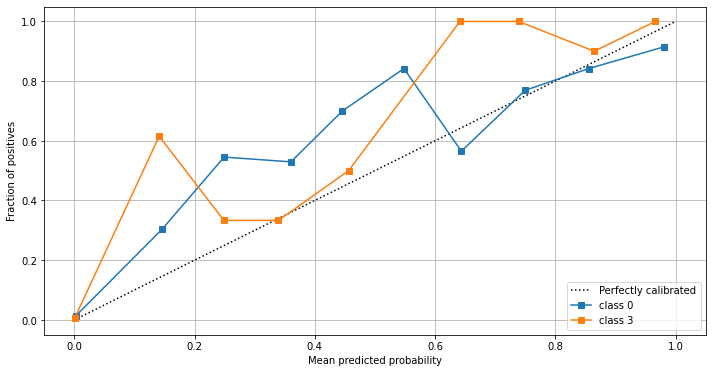

In [16]:
multiout_xgb_model = MultiOutputClassifier(xgb.XGBClassifier(
    n_estimators=400, max_depth=20, tree_method='gpu_hist'
), n_jobs=-1)
multiout_xgb_model.fit(train_X, train_Y)

calibration_plot(multiout_xgb_model, dev_X, dev_Y)

Best Threshold=0.17474, F-Score=0.84635
Best Threshold=0.49710, F-Score=0.81887
Best Threshold=0.13141, F-Score=0.78756
Best Threshold=0.02798, F-Score=0.74847


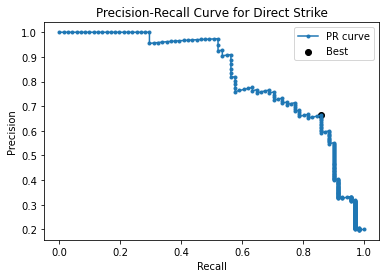

[19:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [17]:
best_thresholds, best_f1_scores = optimize_thresholds(multiout_xgb_model, dev_X, dev_Y)

In [18]:
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

[19:15:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy on training data: 0.9999727416
Accuracy of classifier on dev set: 0.9399067942
              precision    recall  f1-score   support

           0    0.82512   0.86563   0.84489       387
           1    0.84047   0.79412   0.81664       272
           2    0.78125   0.78125   0.78125        96
           3    0.65934   0.84507   0.74074        71

   micro avg    0.80706   0.83051   0.81862       826
   macro avg    0.77655   0.82152   0.79588       826
weighted avg    0.81083   0.83051   0.81924       826
 samples avg    0.09449   0.09482   0.09256       826



In [18]:
save_sklearn_model_to_file(multiout_xgb_model, "newvars_xgboost_multioutput_400")

### Time Series

In [19]:
dataset = pd.read_pickle('../Dataset/baseline_dataset_ts_24.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 54 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LOW_IMPACT     45293 non-null  bool   
 1   MID_IMPACT     45293 non-null  bool   
 2   BIG_IMPACT     45293 non-null  bool   
 3   DIRECT_STRIKE  45293 non-null  bool   
 4   MM00           45293 non-null  int32  
 5   DD00           45293 non-null  int32  
 6   HH00           45293 non-null  int32  
 7   MI_STATUS00    45293 non-null  bool   
 8   LI_STATUS00    45293 non-null  bool   
 9   SI_STATUS00    45293 non-null  bool   
 10  DS_STATUS00    45293 non-null  bool   
 11  LAT00          45293 non-null  float32
 12  LON00          45293 non-null  float32
 13  VMAX00         45293 non-null  int32  
 14  MM06           45293 non-null  int32  
 15  DD06           45293 non-null  int32  
 16  HH06           45293 non-null  int32  
 17  MI_STATUS06    45293 non-null  bool   
 18  LI_STA

In [20]:
def pandasToXY(dataframe):
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int) # different!
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36686; Dev set size: 4077; Testing set size: 4530


Brier score losses: (the smaller the better)
Class 0, no calibration: 0.023252
Class 1, no calibration: 0.015669
Class 2, no calibration: 0.009125
Class 3, no calibration: 0.007812


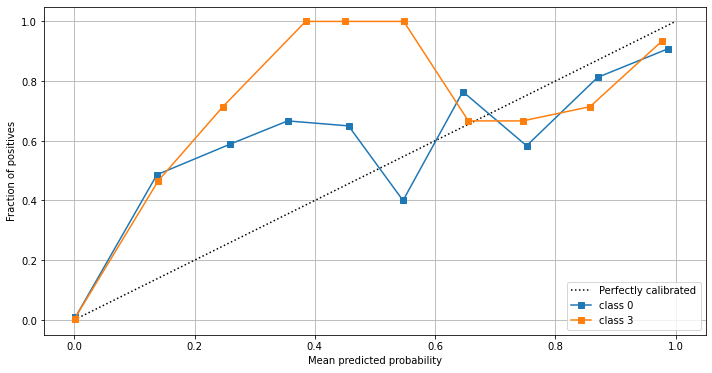

In [21]:
multiout_xgb_model = MultiOutputClassifier(xgb.XGBClassifier(
    n_estimators=400, max_depth=20, tree_method='gpu_hist'
), n_jobs=-1)
multiout_xgb_model.fit(train_X, train_Y)

calibration_plot(multiout_xgb_model, dev_X, dev_Y)

Best Threshold=0.10201, F-Score=0.83834
Best Threshold=0.38343, F-Score=0.84660
Best Threshold=0.20033, F-Score=0.73810
Best Threshold=0.07359, F-Score=0.77372


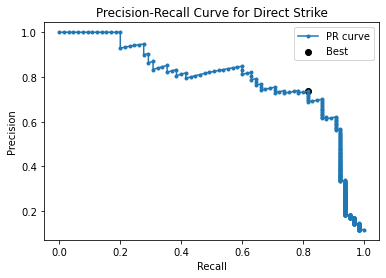

In [22]:
best_thresholds, best_f1_scores = optimize_thresholds(multiout_xgb_model, dev_X, dev_Y)

In [23]:
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9465293108
              precision    recall  f1-score   support

           0    0.78495   0.89571   0.83668       326
           1    0.87149   0.81887   0.84436       265
           2    0.75309   0.70930   0.73054        86
           3    0.73239   0.80000   0.76471        65

   micro avg    0.80466   0.83827   0.82112       742
   macro avg    0.78548   0.80597   0.79407       742
weighted avg    0.80756   0.83827   0.82081       742
 samples avg    0.09294   0.09206   0.09094       742



In [ ]:
save_sklearn_model_to_file(multiout_xgb_model, "ts_xgboost_multioutput_400")

### Time series and alternative variable layout

In [6]:
dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_24.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44837 entries, 0 to 44836
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LOW_IMPACT     44837 non-null  bool   
 1   MID_IMPACT     44837 non-null  bool   
 2   BIG_IMPACT     44837 non-null  bool   
 3   DIRECT_STRIKE  44837 non-null  bool   
 4   MM00           44837 non-null  int32  
 5   DD00           44837 non-null  int32  
 6   HH00           44837 non-null  int32  
 7   MI_STATUS00    44837 non-null  bool   
 8   LI_STATUS00    44837 non-null  bool   
 9   SI_STATUS00    44837 non-null  bool   
 10  DS_STATUS00    44837 non-null  bool   
 11  DIST00         44837 non-null  float64
 12  AZM00          44837 non-null  float64
 13  SPEED00        44837 non-null  int32  
 14  DIR00          44837 non-null  int32  
 15  VMAX00         44837 non-null  int32  
 16  DVMAX00        44837 non-null  int32  
 17  MM06           44837 non-null  int32  
 18  DD06  

In [7]:
def pandasToXY(dataframe):
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int) # different!
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36317; Dev set size: 4036; Testing set size: 4484


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.021339
Class 1, no calibration: 0.017639
Class 2, no calibration: 0.009729
Class 3, no calibration: 0.008026


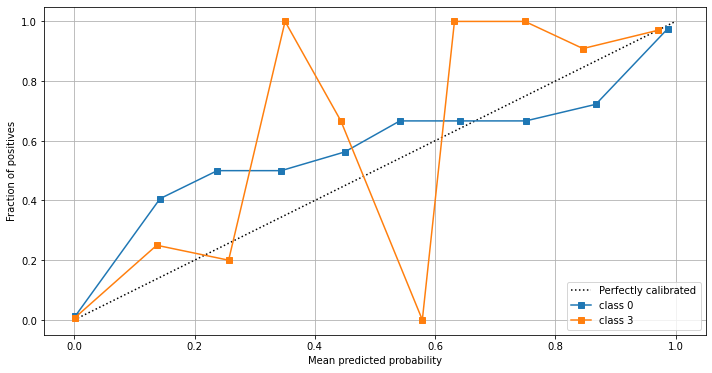

In [13]:
multiout_xgb_model = MultiOutputClassifier(xgb.XGBClassifier(
    n_estimators=700, max_depth=20, tree_method='gpu_hist'
), n_jobs=-1)
multiout_xgb_model.fit(train_X, train_Y)

calibration_plot(multiout_xgb_model, dev_X, dev_Y)

Best Threshold=0.23105, F-Score=0.85635
Best Threshold=0.14913, F-Score=0.85034
Best Threshold=0.13042, F-Score=0.78302
Best Threshold=0.27177, F-Score=0.78378


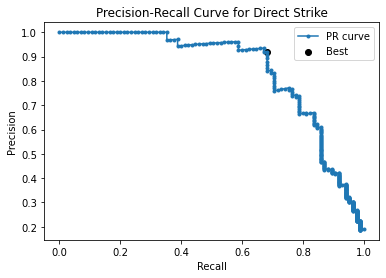

In [14]:
best_thresholds, best_f1_scores = optimize_thresholds(multiout_xgb_model, dev_X, dev_Y)

In [15]:
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9459861249
              precision    recall  f1-score   support

           0    0.87931   0.83152   0.85475       368
           1    0.82724   0.87063   0.84838       286
           2    0.83673   0.72566   0.77725       113
           3    0.91935   0.67059   0.77551        85

   micro avg    0.85785   0.81455   0.83564       852
   macro avg    0.86566   0.77460   0.81397       852
weighted avg    0.86018   0.81455   0.83443       852
 samples avg    0.09653   0.09537   0.09403       852



In [16]:
save_sklearn_model_to_file(multiout_xgb_model, "tsnv_xgboost_multioutput_400")

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.025549
Class 1, no calibration: 0.020899
Class 2, no calibration: 0.011217
Class 3, no calibration: 0.010123


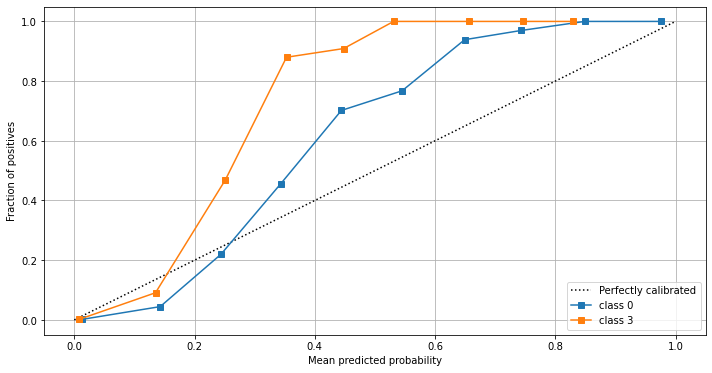

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = ExtraTreesClassifier(
    n_estimators=400, max_depth=25, n_jobs=-1, verbose=0
)
extra_trees_clf.fit(train_X, train_Y)

calibration_plot(extra_trees_clf, dev_X, dev_Y)

Best Threshold=0.30500, F-Score=0.84031
Best Threshold=0.33779, F-Score=0.82192
Best Threshold=0.29948, F-Score=0.77626
Best Threshold=0.22208, F-Score=0.81176


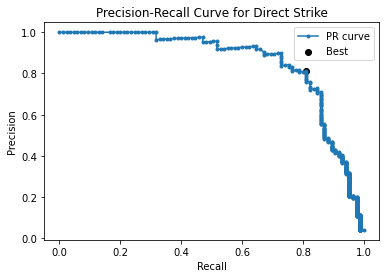

In [25]:
best_thresholds, best_f1_scores = optimize_thresholds(extra_trees_clf, dev_X, dev_Y)

In [26]:
preds = predictions_with_thresholds(extra_trees_clf, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

preds = predictions_with_thresholds(extra_trees_clf, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 0.9995043643
Accuracy of classifier on dev set: 0.9353320119
              precision    recall  f1-score   support

           0    0.81013   0.86957   0.83879       368
           1    0.80471   0.83566   0.81990       286
           2    0.80000   0.74336   0.77064       113
           3    0.80952   0.80000   0.80473        85

   micro avg    0.80704   0.83451   0.82054       852
   macro avg    0.80609   0.81215   0.80852       852
weighted avg    0.80691   0.83451   0.82001       852
 samples avg    0.09680   0.09832   0.09492       852

[15:35:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 

### Downsampled: 2008-2019 data only

Solid proof that smaller datasets are somewhat better.

In [10]:
dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_2008_24.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6957 entries, 0 to 6956
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LOW_IMPACT     6957 non-null   bool   
 1   MID_IMPACT     6957 non-null   bool   
 2   BIG_IMPACT     6957 non-null   bool   
 3   DIRECT_STRIKE  6957 non-null   bool   
 4   MM00           6957 non-null   int32  
 5   DD00           6957 non-null   int32  
 6   HH00           6957 non-null   int32  
 7   MI_STATUS00    6957 non-null   bool   
 8   LI_STATUS00    6957 non-null   bool   
 9   SI_STATUS00    6957 non-null   bool   
 10  DS_STATUS00    6957 non-null   bool   
 11  DIST00         6957 non-null   float64
 12  AZM00          6957 non-null   float64
 13  SPEED00        6957 non-null   int32  
 14  DIR00          6957 non-null   int32  
 15  VMAX00         6957 non-null   int32  
 16  DVMAX00        6957 non-null   int32  
 17  MM06           6957 non-null   int32  
 18  DD06    

In [11]:
def pandasToXY(dataframe):
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int) # different!
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5634; Dev set size: 627; Testing set size: 696


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.013957
Class 1, no calibration: 0.006784
Class 2, no calibration: 0.003802
Class 3, no calibration: 0.003947


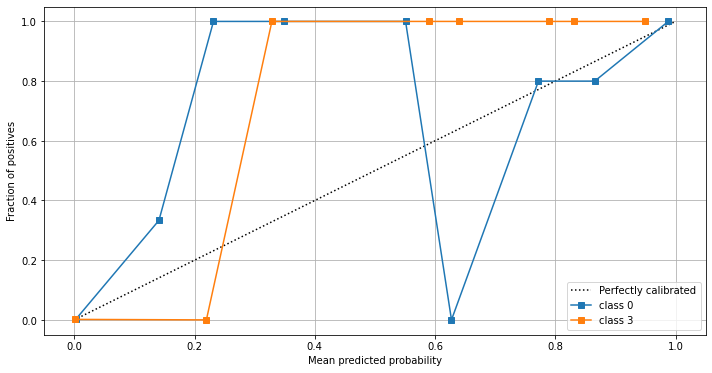

In [12]:
multiout_xgb_model = MultiOutputClassifier(xgb.XGBClassifier(
    #n_estimators=700, max_depth=20, 
    tree_method='gpu_hist', random_state=42
), n_jobs=-1)
multiout_xgb_model.fit(train_X, train_Y)

calibration_plot(multiout_xgb_model, dev_X, dev_Y)

Best Threshold=0.14693, F-Score=0.94915
Best Threshold=0.59976, F-Score=0.94253
Best Threshold=0.39765, F-Score=0.96970
Best Threshold=0.32841, F-Score=0.95652


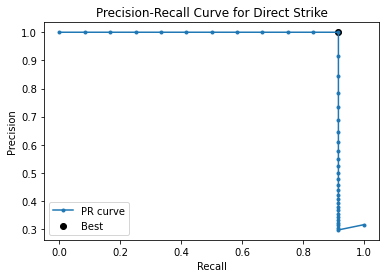

In [13]:
best_thresholds, best_f1_scores = optimize_thresholds(multiout_xgb_model, dev_X, dev_Y)

In [14]:
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9728867624
              precision    recall  f1-score   support

           0    0.91667   0.96491   0.94017        57
           1    0.97561   0.88889   0.93023        45
           2    0.93750   0.93750   0.93750        16
           3    1.00000   0.83333   0.90909        12

   micro avg    0.94488   0.92308   0.93385       130
   macro avg    0.95744   0.90616   0.92925       130
weighted avg    0.94733   0.92308   0.93353       130
 samples avg    0.09623   0.09370   0.09384       130



Brier score losses: (the smaller the better)
Class 0, no calibration: 0.012387
Class 1, no calibration: 0.007504
Class 2, no calibration: 0.005738
Class 3, no calibration: 0.003904


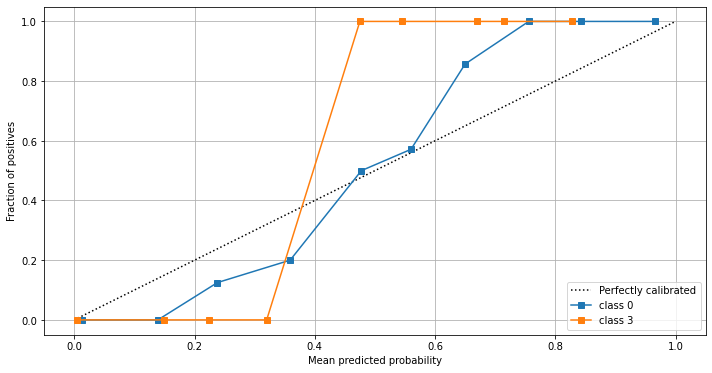

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = ExtraTreesClassifier(
    n_estimators=200, random_state=42, n_jobs=-1, verbose=0
)
extra_trees_clf.fit(train_X, train_Y)

calibration_plot(extra_trees_clf, dev_X, dev_Y)

Best Threshold=0.48500, F-Score=0.94017
Best Threshold=0.41500, F-Score=0.98876
Best Threshold=0.46500, F-Score=0.96970
Best Threshold=0.46000, F-Score=1.00000


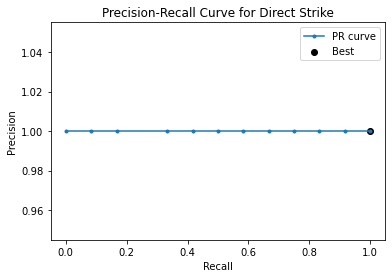

In [16]:
best_thresholds, best_f1_scores = optimize_thresholds(extra_trees_clf, dev_X, dev_Y)

In [17]:
preds = predictions_with_thresholds(extra_trees_clf, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

preds = predictions_with_thresholds(extra_trees_clf, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9824561404
              precision    recall  f1-score   support

           0    0.91525   0.94737   0.93103        57
           1    1.00000   0.95556   0.97727        45
           2    0.93750   0.93750   0.93750        16
           3    1.00000   0.91667   0.95652        12

   micro avg    0.95349   0.94615   0.94981       130
   macro avg    0.96319   0.93927   0.95058       130
weighted avg    0.95515   0.94615   0.95019       130
 samples avg    0.09397   0.09556   0.09407       130

